In [1]:
import numpy as np
import numpy.random as npr

import tensorflow as tf

!pip install py-pde
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph
from pde.tools.numba import jit

from tqdm import trange

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

tf.random.set_seed(1234)
npr.seed(1234)

     |████████████████████████████████| 307kB 23.4MB/s 


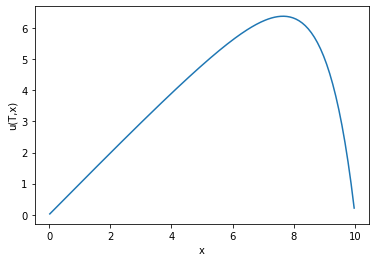

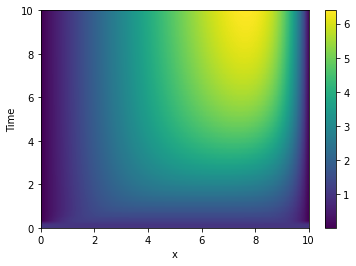

In [27]:
class AdvectionDiffusion1dPDE(PDEBase):
    def __init__(self, Pec=1.0, bc='natural'):
        """ initialize the class with a Peclet number and boundary conditions
        for the actual field """
        self.Pec = Pec
        self.bc = bc

    def evolution_rate(self, state, t=0):
        """ numpy implementation of the evolution equation """
        assert state.grid.dim == 1  # ensure the state is one-dimensional
        state_lapacian = state.laplace(bc=self.bc)
        state_gradient = state.gradient(bc=self.bc)
        return state_lapacian - self.Pec*state_gradient + self.Pec

    def _make_pde_rhs_numba(self, state):
        """ the numba-accelerated evolution equation """
        assert state.grid.dim == 1  # ensure the state is one-dimensional
        # make class attributes locally available
        Pec = self.Pec

        # create operators
        laplace_u = state.grid.get_operator('laplace', bc=self.bc)
        gradient_u = state.grid.get_operator('gradient', bc=self.bc)

        @jit
        def pde_rhs(state_data, t=0):
            """ compiled helper function evaluating right hand side """
            state_lapacian = laplace_u(state_data)
            state_gradient = gradient_u(state_data)
            return state_lapacian - Pec*state_gradient + Pec
        return pde_rhs

# initialize the equation and the space
grid = CartesianGrid([[0, 10]], [200], periodic=False)
field = ScalarField(grid, data=1, label='u(T,x)')

# solve the equation and store the trajectory
eq = AdvectionDiffusion1dPDE(Pec=1.0, bc=[{'type': 'value', 'value': 0}, {'type': 'value', 'value': 0}])
storage = MemoryStorage()
result = eq.solve(field, t_range=10, tracker=["progress", storage.tracker(0.25)])

result.plot()
# plot the trajectory as a space-time plot
plot_kymograph(storage)

In [ ]:
class Data():
    def __init__(self, param_dict, mode):
        if mode != 'solver' and mode != 'inverse':
            raise ValueError('Mode can only be "solver" or "inverse"!')

        self.mode   = mode
        self.d_x    = param_dict['d_x']
        self.L      = self.d_x[1] - self.d_x[0]
        self.ic     = param_dict['ic']
        self.Pec    = param_dict['Pec']
        self.n_data = param_dict['n_data'] # boundary condition data on u(x) for 'solver' mode + few interior data points for 'inverse' mode
        self.n_res  = param_dict['n_res']  # number of collocation points for minimizing the PDE residual
        self.n_test = param_dict['n_test'] # test data for validating the model predictions

        # define source term
        self.s = param_dict['s']
        # define source term (in Tensorflow semantics)
        self.s_tf = param_dict['s_tf']

        self.prep_data()

    def prep_data(self):
        # define exact solution (for validation purposes)    
        def u(x):
            return (x/self.L) - (1-np.exp(self.Pec*x/self.L))/(1-np.exp(self.Pec))
    
        if self.mode == 'solver':
            lb  = np.array([self.d_x[0]])         # left boundary of the domain
            ub  = np.array([self.d_x[1]])         # right boundary of the domain

            # generate training data
            self.x_d = np.linspace(lb, ub, self.n_data)     # location of boundary points
            self.x_r = np.linspace(lb, ub, self.n_res)      # location of collocation points for PDE residual
            self.y_d = u(self.x_d)                          # solution at boundary points

            # generate test data
            self.x_test = np.linspace(lb, ub, self.n_test)
            self.y_test = u(self.x_test)
        else:
            lb  = np.array([self.d_x[0]])         # left boundary of the domain
            ub  = np.array([self.d_x[1]])         # right boundary of the domain

            # generate training data
            idx = [0, *list(npr.choice(self.n_res, self.n_data-2, replace=False)), self.n_res-1]
            self.x_r = np.linspace(lb, ub, self.n_res)      # location of collocation points for PDE residual
            self.x_d = self.x_r[idx]
            self.y_d = u(self.x_d)                          # solution at boundary points + interior points
            self.y_d[1:-1] += npr.normal(0.0, 0.5*self.y_d.std(0), size=self.y_d[1:-1].shape)

            # generate test data
            self.x_test = np.linspace(lb, ub, self.n_test)
            self.y_test = u(self.x_test)

In [ ]:
class Dense(tf.Module):
    def __init__(self, input_dim, output_dim, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([input_dim, output_dim]), name=f'weights_{name}')
        self.b = tf.Variable(tf.zeros([output_dim]), name=f'biases_{name}')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b
    
class MLP(tf.Module):
    def __init__(self, input_size, output_size, hidden_sizes, name=None):
        super().__init__(name=name)
        self.layers = []
        i = 1
        with self.name_scope:
            for size in hidden_sizes:
                self.layers.append(Dense(input_dim=input_size, output_dim=size, name=f'layer_{i}'))
                self.layers.append(tf.nn.softplus)
                input_size = size
                i += 1
            self.layers.append(Dense(input_dim=input_size, output_dim=output_size, name='layer_output'))
            
    @tf.function
    def __call__(self, t, x):
        if t == None:
            z = x
        else:
            z = tf.concat([t, x], axis=-1)
        for layer in self.layers:
            z = layer(z)
        return z

In [ ]:
class AdvDiff1dNN():
    def __init__(self, data, layers, loss_coeff):

        self.mode = data.mode
        X_dat = data.x_d / data.L
        y_dat = data.y_d
        X_res = data.x_r / data.L
        self.s = data.s_tf
        if self.mode == 'solver':
            self.Pec = tf.constant(data.Pec)
        else:
            self.Pec = tf.Variable(0.01, name='Pec_unknown')
            self.Pec.assign(tf.exp(self.Pec))

        # scaling factors
        self.Xmean, self.Xstd = X_res.mean(0), X_res.std(0)
        if self.mode == 'solver':
            self.Ymean, self.Ystd = 0.0, 1.0
        else:
            self.Ymean, self.Ystd = y_dat.mean(0), y_dat.std(0)

        # normalize data
        X_dat = (X_dat-self.Xmean) / self.Xstd
        X_res = (X_res-self.Xmean) / self.Xstd
        y_dat = (y_dat-self.Ymean) / self.Ystd
        
        # coefficients to give each loss term proper weight in the total loss (improves the optimization speed)
        self.alpha = tf.constant(loss_coeff[0])
        self.beta  = tf.constant(loss_coeff[1])

        # store the normalized training data
        self.X_d = X_dat.astype(np.float32)
        self.y_d = y_dat.astype(np.float32)
        self.X_r = X_res.astype(np.float32)
        self.y_r = np.zeros((X_res.shape[0], 1), dtype=np.float32)

        # set up network initialization and evaluation functions
        self.layers = layers
        self.Unet = MLP(input_size=layers[0], output_size=layers[-1], hidden_sizes=layers[1:-1], name='Unet')
        
        self.variables = self.Unet.trainable_variables
        if self.mode == 'inverse':
            self.variables = (*self.variables, self.Pec)
        print('Trainable parameters:')
        print('===================================')
        for var in self.variables:
            print(var.name, ', shape:', list(var.shape))
        print('\n')
        
        # use tf optimizers to set optimizer initialization and learning rate scheduler
        initial_lr = 1e-3
        self.opt = tf.optimizers.Adam(lr=initial_lr)
        self.lr_scheduler = tf.optimizers.schedules.ExponentialDecay(initial_lr,
                                                                     decay_steps=1000,
                                                                     decay_rate=0.9,
                                                                     staircase=True)
        
        # define mean squared error loss
        self.MSE = tf.losses.MeanSquaredError()

        # logger to monitor the loss function
        self.loss_dat_log = []
        self.loss_res_log = []

    # forward pass for u
    def forward_U(self, t, x):
        return self.Unet(t, x)
    
    # forward pass for equation residual
    def forward_R(self, t, x):
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            with tf.GradientTape() as tape1:
                tape1.watch(x)
                u = self.forward_U(t, x)
            u_x = tape1.gradient(u, x) * self.Ystd / self.Xstd
        u_xx = tape2.gradient(u_x, x) / self.Xstd
        residual = u_xx - self.Pec*u_x + self.Pec*self.s(x*self.Xstd+self.Xmean)
        return residual
    
    @tf.function
    def loss(self, batch):
        X_d, y_d, X_r, y_r = batch
        loss_d = self.MSE(tf.convert_to_tensor(y_d), self.forward_U(None, tf.convert_to_tensor(X_d)))
        loss_r = self.MSE(tf.convert_to_tensor(y_r), self.forward_R(None, tf.convert_to_tensor(X_r)))
        return loss_d, loss_r

    def data_stream(self, n, num_batches, batch_size):
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(n)
            for i in range(num_batches):
                batch_idx = perm[i*batch_size:(i+1)*batch_size]
                yield self.X_d, self.y_d, self.X_r[batch_idx], self.y_r[batch_idx]
    
    def train(self, num_epochs=100, batch_size=64):   
        n = self.X_r.shape[0]
        num_complete_batches, leftover = divmod(n, batch_size)
        num_batches = num_complete_batches + bool(leftover)
        assert n > num_batches
        batches = self.data_stream(n, num_batches, batch_size)
        
        pbar = trange(num_epochs)
        for epoch in pbar:
            loss_dat = 0.
            loss_res = 0.
            loss_tot = 0.
            for _ in range(num_batches):
                batch = next(batches)
                with tf.GradientTape(persistent=True) as tape:
                    loss_d, loss_r = self.loss(batch)
                    loss_t = self.alpha*loss_d + self.beta*loss_r
                grads = tape.gradient(loss_t, self.variables)
                self.opt.apply_gradients(zip(grads, self.variables))
                loss_dat += loss_d
                loss_res += loss_r
                loss_tot += loss_t
            pbar.set_postfix({'Total Loss': loss_tot.numpy()/num_batches})
            self.loss_dat_log.append(loss_dat.numpy()/num_batches)
            self.loss_res_log.append(loss_res.numpy()/num_batches)
            self.lr_scheduler(epoch)
    
    # infer solution at test points
    def predict_U(self, x_pred):
        x_pred = (x_pred-self.Xmean) / self.Xstd
        y_pred = self.forward_U(None, x_pred.astype(np.float32))
        y_pred = y_pred*self.Ystd + self.Ymean
        return y_pred

In [ ]:
# set hyperparameters
BATCH_SIZE = 256
NUM_EPOCHS = 2000
# fully-connected neural net architecture (dimensions of each layer)
layers = [1, 16, 16, 1]
# coefficients for the loss terms: [loss_data_coeff, loss_residual_coeff]
loss_coeff = [1.0, 0.1]

# define the problem and generate training/test data
param_dict = {
    'd_x'   : [0., 10.],
    'bc'    : [0., 0.],
    'time'  : [0., 100.],
    'ic'    : lambda x: (x-0.5)**2,
    'Pec'   : 1.,
    'n_data': 12+2,
    'n_res' : 2048,
    'n_test': 512,
    's'     : lambda x: 1.0,
    's_tf'  : lambda x: 1.0
}
data = Data(param_dict, mode='inverse')

# define equation-informed model
model = AdvDiff1dNN(data, layers, loss_coeff)

Trainable parameters:
Unet/biases_layer_1:0 , shape: [16]
Unet/weights_layer_1:0 , shape: [1, 16]
Unet/biases_layer_2:0 , shape: [16]
Unet/weights_layer_2:0 , shape: [16, 16]
Unet/biases_layer_output:0 , shape: [1]
Unet/weights_layer_output:0 , shape: [16, 1]
Pec_unknown:0 , shape: []




In [ ]:
model.train(num_epochs=2000, batch_size=BATCH_SIZE)





  0%|          | 0/2000 [00:00<?, ?it/s]



  0%|          | 0/2000 [00:04<?, ?it/s, Total Loss=682]



  0%|          | 1/2000 [00:04<2:26:51,  4.41s/it, Total Loss=682]



  0%|          | 1/2000 [00:04<2:26:51,  4.41s/it, Total Loss=606]



  0%|          | 1/2000 [00:04<2:26:51,  4.41s/it, Total Loss=537]



  0%|          | 3/2000 [00:04<1:43:25,  3.11s/it, Total Loss=537]



  0%|          | 3/2000 [00:04<1:43:25,  3.11s/it, Total Loss=472]



  0%|          | 3/2000 [00:04<1:43:25,  3.11s/it, Total Loss=414]



  0%|          | 5/2000 [00:04<1:13:03,  2.20s/it, Total Loss=414]



  0%|          | 5/2000 [00:04<1:13:03,  2.20s/it, Total Loss=361]



  0%|          | 5/2000 [00:04<1:13:03,  2.20s/it, Total Loss=313]



  0%|          | 7/2000 [00:04<51:50,  1.56s/it, Total Loss=313]  



  0%|          | 7/2000 [00:04<51:50,  1.56s/it, Total Loss=270]



  0%|          | 7/2000 [00:05<51:50,  1.56s/it, Total Loss=231]



  0%|          | 9/2000 [00:05<37:04,  1.12s/it, Total L

KeyboardInterrupt: ignored

In [ ]:
# inference using the trained model
y_pred = model.predict_U(data.x_test/data.L)
error = np.linalg.norm(data.y_test-y_pred, 2) / np.linalg.norm(data.y_test, 2)
print('Relative L2 error: %.3e' % (error))

Relative L2 error: 4.924e-02


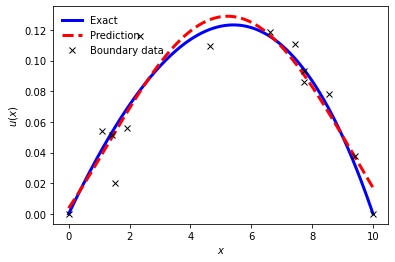

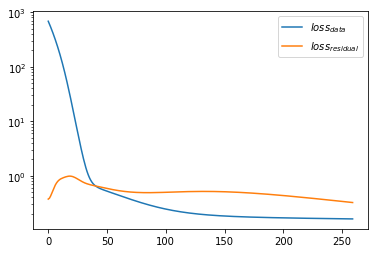

In [ ]:
# plot the solution
plt.figure(1)
plt.plot(data.x_test, data.y_test, 'b-', linewidth=3, label="Exact")
plt.plot(data.x_test, y_pred, 'r--', linewidth=3, label="Prediction")
plt.plot(data.x_d, data.y_d, 'kx', linewidth=3, label="Boundary data")
plt.legend(frameon=False, loc='upper left')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.show()

# plot the history of losses
fig = plt.figure(2)
ax = fig.add_subplot(1, 1, 1)
ax.plot(model.loss_dat_log, label='$loss_{data}$')
ax.plot(model.loss_res_log, label='$loss_{residual}$')
ax.set_yscale('log')
plt.legend()
plt.show()

In [ ]:
model.Pec.numpy()

0.57426566